# Ejemplo PRM (Probabilistic Roadmap)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oscar-ramos/robotica-autonoma-python/blob/main/6-Planificacion-Movimiento/6-06-PRM.ipynb)


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

### Algoritmo de búsqueda (Dijkstra)

In [2]:
class Node:
    """
    Node class for dijkstra search
    """
    def __init__(self, x, y, cost, parent_index):
        self.x = x
        self.y = y
        self.cost = cost
        self.parent_index = parent_index

    def __str__(self):
        return str(self.x) + "," + str(self.y) + "," +\
               str(self.cost) + "," + str(self.parent_index)


def dijkstra_planning(S, G, road_map, sample_x, sample_y, show_animation=True):
    """
    S - start  position [m]
    G - goal position [m]
    road_map - roadmap [m]
    sample_x - samples in x [m]
    sample_y - samples in y [m]
    @return: Two lists of path coordinates ([x1, x2, ...], [y1, y2, ...]), empty list when no path was found
    """

    start_node = Node(S[0], S[1], 0.0, -1)
    goal_node = Node(G[0], G[1], 0.0, -1)
    open_set, closed_set = dict(), dict()
    open_set[len(road_map) - 2] = start_node
    path_found = True

    while True:
        if not open_set:
            print("Cannot find path")
            path_found = False
            break

        c_id = min(open_set, key=lambda o: open_set[o].cost)
        current = open_set[c_id]

        # Show graph
        if show_animation and len(closed_set.keys()) % 2 == 0:
            # For stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect(
                'key_release_event',
                lambda event: [exit(0) if event.key == 'escape' else None])
            plt.plot(current.x, current.y, "xg")
            plt.pause(0.0001)

        if c_id == (len(road_map) - 1):
            print("Goal found!")
            goal_node.parent_index = current.parent_index
            goal_node.cost = current.cost
            break

        # Remove the item from the open set
        del open_set[c_id]
        # Add it to the closed set
        closed_set[c_id] = current

        # Expand search grid based on motion model
        for i in range(len(road_map[c_id])):
            n_id = road_map[c_id][i]
            dx = sample_x[n_id] - current.x
            dy = sample_y[n_id] - current.y
            d = np.hypot(dx, dy)
            node = Node(sample_x[n_id], sample_y[n_id],
                        current.cost + d, c_id)

            if n_id in closed_set:
                continue
            # Otherwise if it is already in the open set
            if n_id in open_set:
                if open_set[n_id].cost > node.cost:
                    open_set[n_id].cost = node.cost
                    open_set[n_id].parent_index = c_id
            else:
                open_set[n_id] = node

    if path_found is False:
        return [], []

    # Generate final course
    rx, ry = [goal_node.x], [goal_node.y]
    parent_index = goal_node.parent_index
    while parent_index != -1:
        n = closed_set[parent_index]
        rx.append(n.x)
        ry.append(n.y)
        parent_index = n.parent_index

    return rx, ry

### PRM

In [3]:
class PRM(object):

    def __init__(self, S, G, ox, oy, radio_robot):
        self.start = S
        self.goal = G
        self.ox = ox
        self.oy = oy
        self.rr = radio_robot

    def generate_samples(self, n_samples):
        """
        n_samples - Puntos de muestra
        """
        self.obstacle_kd_tree = cKDTree(np.vstack((self.ox, self.oy)).T)
        max_x = max(self.ox); max_y = max(self.oy)
        min_x = min(self.ox); min_y = min(self.oy)
        self.sample_x, self.sample_y = [], []

        while len(self.sample_x) <= n_samples:
            tx = (random.random()*(max_x - min_x)) + min_x
            ty = (random.random()*(max_y - min_y)) + min_y
            dist, index = self.obstacle_kd_tree.query([tx, ty])
            if dist >= self.rr:
                self.sample_x.append(tx)
                self.sample_y.append(ty)

        self.sample_x.append(self.start[0])
        self.sample_y.append(self.start[1])
        self.sample_x.append(self.goal[0])
        self.sample_y.append(self.goal[1])

    def generate_roadmap(self, n_knn=10, max_edge_len=30):
        """
        Roadmap generation
            n_knn - Number of edges from a sample
            max_edge_len - Max length for each edge

        """
        self.max_edge_len = max_edge_len

        self.road_map = []
        n_sample = len(self.sample_x)
        sample_kd_tree = cKDTree(np.vstack((self.sample_x, self.sample_y)).T)

        for (i, ix, iy) in zip(range(n_sample), self.sample_x, self.sample_y):
            dists, indexes = sample_kd_tree.query([ix, iy], k=n_sample)
            edge_id = []
            for ii in range(1, len(indexes)):
                nx = self.sample_x[indexes[ii]]
                ny = self.sample_y[indexes[ii]]
                if not self._is_collision(ix, iy, nx, ny):
                    edge_id.append(indexes[ii])
                if len(edge_id) >= n_knn:
                    break
            self.road_map.append(edge_id)

    def get_samples(self):
        return self.sample_x, self.sample_y

    def get_roadmap(self):
        return self.road_map

    def _is_collision(self, sx, sy, gx, gy):
        x = sx
        y = sy
        dx = gx - sx
        dy = gy - sy
        yaw = np.arctan2(gy-sy, gx-sx)
        d = np.hypot(dx, dy)

        if d >= self.max_edge_len:
            return True

        D = self.rr
        n_step = round(d / D)

        for i in range(n_step):
            dist, _ = self.obstacle_kd_tree.query([x, y])
            if dist <= self.rr:
                return True  # collision
            x += D * np.cos(yaw)
            y += D * np.sin(yaw)

        # Goal point check
        dist, _ = self.obstacle_kd_tree.query([gx, gy])
        if dist <= self.rr:
            return True  # Collision
        return False  # No collision


def plot_roadmap(road_map, sample_x, sample_y):
    for i, _ in enumerate(road_map):
        for ii in range(len(road_map[i])):
            ind = road_map[i][ii]
            plt.plot([sample_x[i], sample_x[ind]],
                     [sample_y[i], sample_y[ind]], "-y", linewidth=0.3)

### Programa principal

In [4]:
# Posición inicial y final
S = [10.0, 10.0]     # start
G = [50.0, 50.0]     # goal
# Tamaño del robot
robot_size = 5.0

# Obstáculos
ox = []; oy = []
# Generación de obstáculos ("paredes")
for i in range(60):
    ox.append(i)
    oy.append(0.0)
for i in range(60):
    ox.append(60.0)
    oy.append(i)
for i in range(61):
    ox.append(i)
    oy.append(60.0)
for i in range(61):
    ox.append(0.0)
    oy.append(i)
for i in range(40):
    ox.append(20.0)
    oy.append(i)
for i in range(40):
    ox.append(40.0)
    oy.append(60.0 - i)

# Generar planificador
planner = PRM(S, G, ox, oy, robot_size)

# Generar configuraciones (muestras) aleatorias
n_samples = 500                     # Número de muestras
planner.generate_samples(n_samples)

# Generar un roadmap (considerando S,G como configuraciones aleatorias)
n_knn = 10            # Número de bordes (líneas) desde un punto muestreado
max_edge_len = 30.0   # Máxima longitud de cada borde (línea)
planner.generate_roadmap(n_knn, max_edge_len)

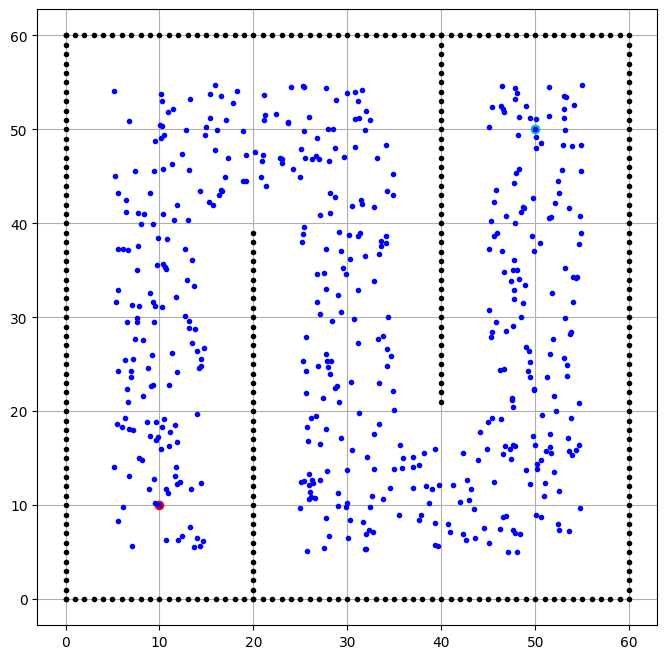

In [5]:
# Mostrar el mapa con el punto inicial y elpunto final
plt.figure(figsize=(8,8))
plt.plot(ox, oy, ".k")
plt.plot(S[0], S[1], "or")
plt.plot(G[0], G[1], "oc")
plt.grid(True)
plt.axis("equal")

# Mostrar las configuraciones (puntos) aleatorias
px, py = planner.get_samples()
plt.plot(px, py, ".b")
plt.show()

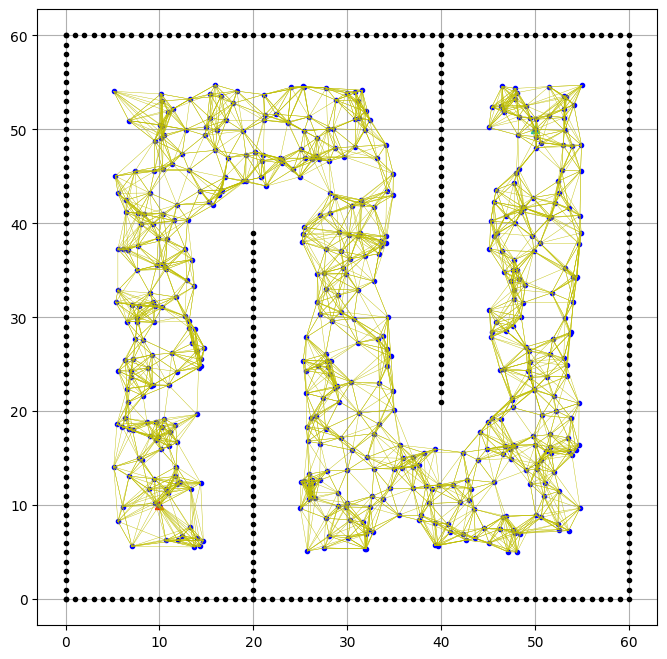

In [6]:
# Mostrar el mapa, punto inicial y punto final
plt.figure(figsize=(8,8))
plt.plot(ox, oy, ".k")
plt.plot(S[0], S[1], "^r")
plt.plot(G[0], G[1], "^c")
plt.grid(True)
plt.axis("equal")

# Mostrar las configuraciones aleatorias
plt.plot(px, py, ".b")

# Mostrar el roadmap generado (en amarillo)
roadmap = planner.get_roadmap()
plot_roadmap(roadmap, px, py)

### Planificación usando Dijkstra

In [ ]:
# %matplotlib qt

Goal found!


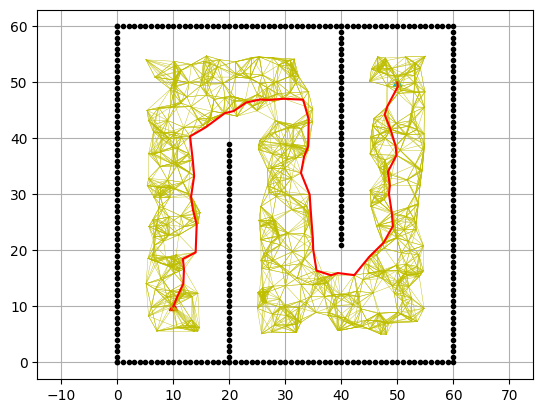

In [8]:
# Mostrar el mapa, punto inicial y punto final
plt.plot(ox, oy, ".k")
plt.plot(S[0], S[1], "^r")
plt.plot(G[0], G[1], "^c")
plt.grid(True)
plt.axis("equal")

# Roadmap generado
plot_roadmap(roadmap, px, py)

# Planificación de la trayectoria (cambiar False a True para animación)
rx, ry = dijkstra_planning(S, G, roadmap, px, py, show_animation=False)

# Mostrar la trayectoria obtenida
plt.plot(rx, ry, "-r")
plt.pause(0.001)
plt.show()